If needed, the hardcoded values and bounds in the following cell can be changed. The script assumes there is a file called data.npz which contains data headers: voltage, power and soc. We also assume time ticks are 1 second.

In [1]:
import numpy as np

data = np.load('data.npz')
U_measured = data['voltage']
power = np.array(data['power'], dtype=np.float64)
soc_measured = data['soc']

# Calculate current
I_load = power / U_measured  # Ensure U_measured has no zeros to avoid division errors

N = len(U_measured)  # Number of data points

# Hardcoded values
Q_total = 259200
max_current_capacity = 40
max_energy_capacity = 500
SOC_data = [0.0752, 0.1705, 0.2677, 0.366, 0.4654, 0.5666, 0.6701, 0.7767, 0.8865, 1.0]

# Bounds derived from conventional battery ranges
bounds = (
    [(0, 0.02)] * 10 +    # R_0_data (Ohmic Resistance)
    [(0, 0.05), (5000, 30000)] +  # R_P (Polarization Resistance), C_P (Capacitance)
    [(3.3, 4.3)] * 10   # Uoc_data (Open Circuit Voltage)
)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from physics.models.battery import BatteryModel, BatteryModelConfig

# Global lists to store predicted SOC and Voltage at each iteration
all_soc_predictions = []
all_voltage_predictions = []

# Define the objective function
def objective(params, visualize=True, optimized=False):
    battery_config = BatteryModelConfig(
        R_0_data=params[:10],  # Optimized R_0_data
        R_P=params[10],        # Optimized R_P
        C_P=params[11],        # Optimized C_P
        Q_total=Q_total,
        SOC_data=SOC_data,     # Hardcoded SOC data
        Uoc_data=params[12:22],# Optimized Uoc_data
        max_current_capacity=max_current_capacity,
        max_energy_capacity=max_energy_capacity
    )
    bm = BatteryModel(battery_config)

    # Run Battery Model
    soc_array, U_predicted = bm.update_array(power, 1, rust=True)
    # Store results for error calculation
    all_soc_predictions.append(soc_array)
    all_voltage_predictions.append(U_predicted)

    # Compute Errors
    mse_voltage = np.mean((U_measured - U_predicted) ** 2)
    mse_soc = np.mean((soc_measured - soc_array) ** 2)

    # Weighted Sum of Errors (Tweak Weights as Needed)
    total_error = (0.35 * mse_voltage) + (0.65 * mse_soc)

    # Visualize Results
    if visualize:
        plot_results(soc_array, U_predicted, power, U_measured, optimized)

    return total_error  # Minimize both SOC & Voltage Error


0.009768, 0.005162, 0.015545, 0.011178, 0.008851, 0.005499, 0.019018, 0.004849, 0.006593, 0.016856, 0.030098, 27636.715457, 3.992526, 3.316302, 3.517652, 3.566728, 3.336582, 4.125598, 4.233229, 3.369910, 4.243663, 3.915974


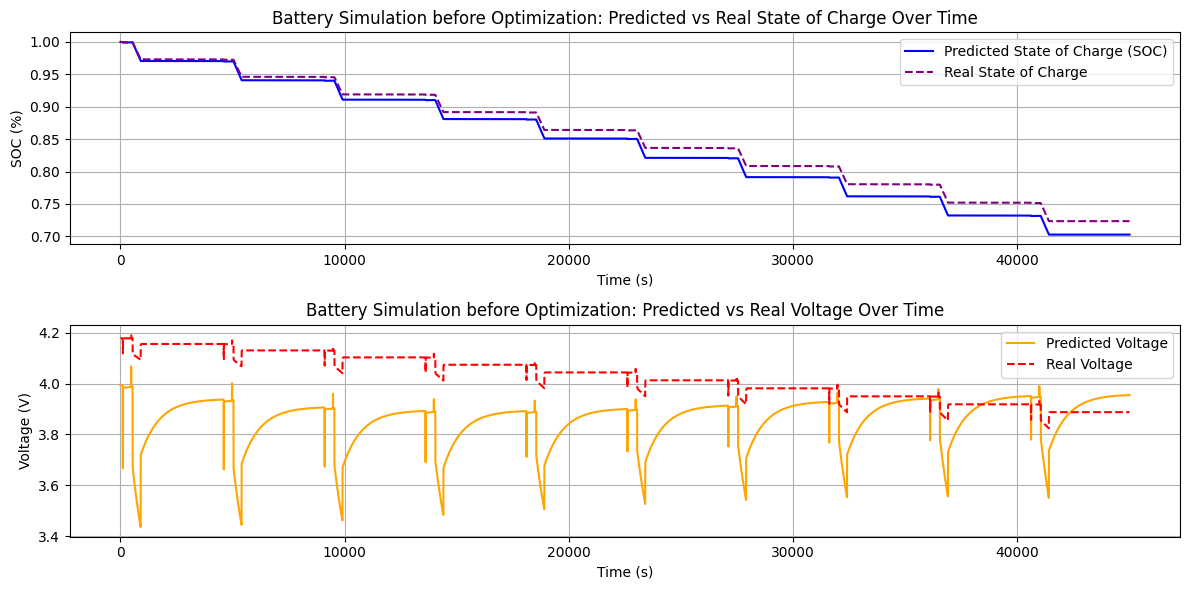

np.float64(0.015989032495119362)

In [3]:
# Function to plot objective function with initial guess
def plot_results(soc_array, voltage_array, power, U_measured, optimize):
    time = np.arange(len(power))

    plt.figure(figsize=(12, 6))

    # Plot SOC
    plt.subplot(2, 1, 1)
    plt.plot(time, soc_array, label="Predicted State of Charge (SOC)", color="blue")
    plt.plot(time, soc_measured, label="Real State of Charge", color="purple", linestyle="dashed")  # Real voltage added

    plt.xlabel("Time (s)")
    plt.ylabel("SOC (%)")
    if optimize:
        plt.title("Battery Simulation after Optimization: Predicted vs Real State of Charge Over Time")
    else:
        plt.title("Battery Simulation before Optimization: Predicted vs Real State of Charge Over Time")

    plt.grid(True)
    plt.legend()

    # Calculate min/max voltage values
    min_voltage = min(np.min(voltage_array), np.min(U_measured))
    max_voltage = max(np.max(voltage_array), np.max(U_measured))
    margin = (max_voltage - min_voltage) * 0.05  # 5% margin for visibility

    # Plot Voltage
    plt.subplot(2, 1, 2)
    plt.plot(time, voltage_array, label="Predicted Voltage", color="orange")
    plt.plot(time, U_measured, label="Real Voltage", color="red", linestyle="dashed")  # Real voltage added
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    if optimize:
        plt.title("Battery Simulation after Optimization: Predicted vs Real Voltage Over Time")
    else:
        plt.title("Battery Simulation before Optimization: Predicted vs Real Voltage Over Time")


    plt.ylim(min_voltage - margin, max_voltage + margin)  # Adjust Y-axis dynamically
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

initial_guess = np.array([np.random.uniform(low, high) for (low, high) in bounds])

print(", ".join([f"{x:.6f}" for x in initial_guess]))

# Run the objective function to visualize and print results
objective(initial_guess)

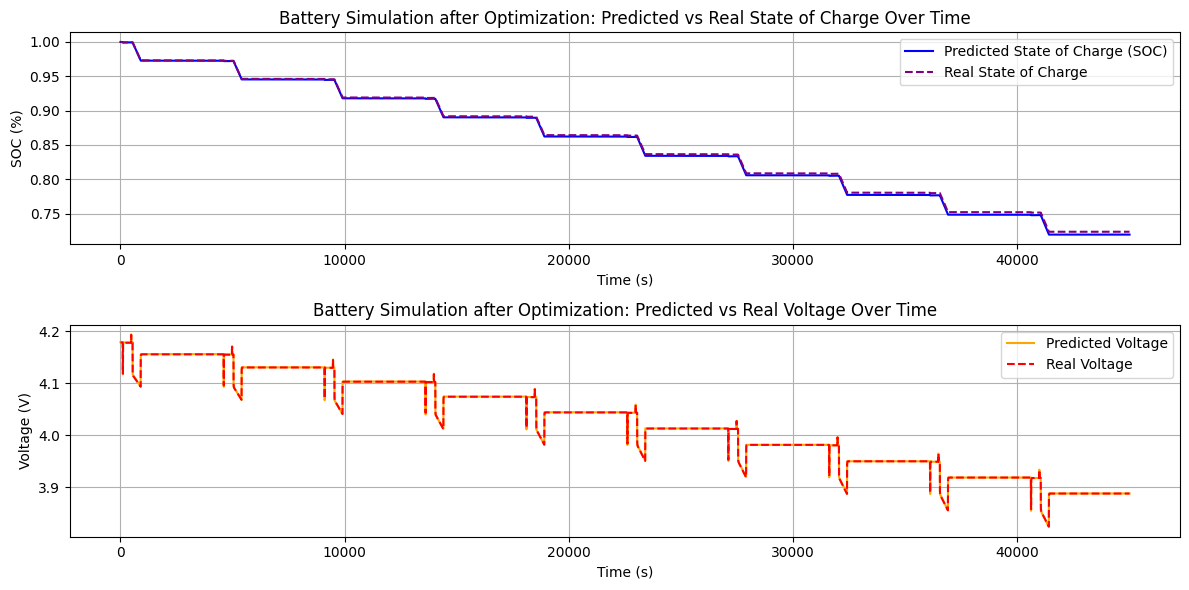


🔹 Optimized Parameters:
- R_0_data (Ohmic Resistance): 0.010194, 0.005378, 0.020000, 0.000116, 0.000006, 0.004892, 0.011414, 0.000206, 0.000202, 0.004551
- R_P (Polarization Resistance): 0.000059
- C_P (Capacitance): 29999.999966
- Uoc_data (Open Circuit Voltage): 4.001501, 4.189685, 3.603004, 3.840591, 3.300053, 4.016210, 4.266272, 3.387837, 4.276442, 4.160998

🔹 **Final MSE Voltage:** 1.439907106702e-03
🔹 **Final MSE SOC:** 1.161051346856e-05
🔹 Final Error (MSE): 4.077505683676e-06



In [4]:
from scipy.optimize import minimize
#Reset the arrays for new optimization run
all_soc_predictions = []
all_voltage_predictions = []
# Define the optimization wrapper function
def optimization_wrapper(params):
    return objective(params, visualize=False)  # Run without plotting for efficiency

# Perform optimization using SciPy's minimize Powell method
result = minimize(optimization_wrapper, initial_guess, method='Powell', bounds=bounds)
objective(result.x, visualize=True, optimized=True)

# Compute error using the stored SOC and Voltage predictions
all_soc_predictions = np.array(all_soc_predictions)
all_voltage_predictions = np.array(all_voltage_predictions)

# Compute MSE for both SOC and Voltage
mse_voltage = np.mean((U_measured - all_voltage_predictions) ** 2)
mse_soc = np.mean((soc_measured - all_soc_predictions) ** 2)

# Optimized Parameters (Formatted with Data Labels)
optimized_params = result.x

formatted_params = f"""
🔹 Optimized Parameters:
- R_0_data (Ohmic Resistance): {", ".join([f"{x:.6f}" for x in optimized_params[:10]])}
- R_P (Polarization Resistance): {optimized_params[10]:.6f}
- C_P (Capacitance): {optimized_params[11]:.6f}
- Uoc_data (Open Circuit Voltage): {", ".join([f"{x:.6f}" for x in optimized_params[12:]])}

🔹 **Final MSE Voltage:** {mse_voltage:.12e}
🔹 **Final MSE SOC:** {mse_soc:.12e}
🔹 Final Error (MSE): {result.fun:.12e}
"""

print(formatted_params)

# Visualize the optimized model
# Run the model with optimized parameters and get predicted voltage

